<a href="https://colab.research.google.com/github/Arslanbaig84/bootstrap/blob/main/my_course_project_AI_CNN_Maize_Crop_Disease_Detection_Project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os

# Specify the new folder name
folder_name = 'my_course_project'

# Define the path for the new folder
folder_path = '/content/drive/MyDrive/Colab Notebooks/' + folder_name

# Change the working directory to the new folder
os.chdir(folder_path)

# Verify the current working directory
!pwd


/content/drive/MyDrive/Colab Notebooks/my_course_project


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
from google.colab import files

# Upload the Kaggle API key (kaggle.json)
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arslanbaig84","key":"6db782694071751115b92fcb3b85c4b5"}'}

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

 95% 152M/161M [00:02<00:00, 85.1MB/s]
100% 161M/161M [00:02<00:00, 59.2MB/s]


In [17]:
import os
import zipfile

# Specify the dataset name and its Kaggle identifier
dataset_name = 'corn-or-maize-leaf-disease-dataset'
kaggle_identifier = 'smaranjitghose/corn-or-maize-leaf-disease-dataset'

# Specify the new folder name
folder_name = 'my_course_project'

# Define the path for the new folder and the dataset zip file
folder_path = '/content/drive/MyDrive/Colab Notebooks/my_course_project/' + folder_name
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/my_course_project/' + dataset_name + '.zip'

# Download the dataset zip file
!kaggle datasets download -d {kaggle_identifier} -p /content/

# Create the new folder
os.makedirs(folder_path, exist_ok=True)

# Extract the dataset into the new folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(folder_path)

# Verify the contents of the new folder
os.listdir(folder_path)

corn-or-maize-leaf-disease-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


['data']

In [18]:
import os
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/my_course_project


In [29]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/my_course_project/data"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    batch_size=32,
    image_size=(256, 256),
    # other parameters...
)

Found 4188 files belonging to 4 classes.


In [30]:
dataset.class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

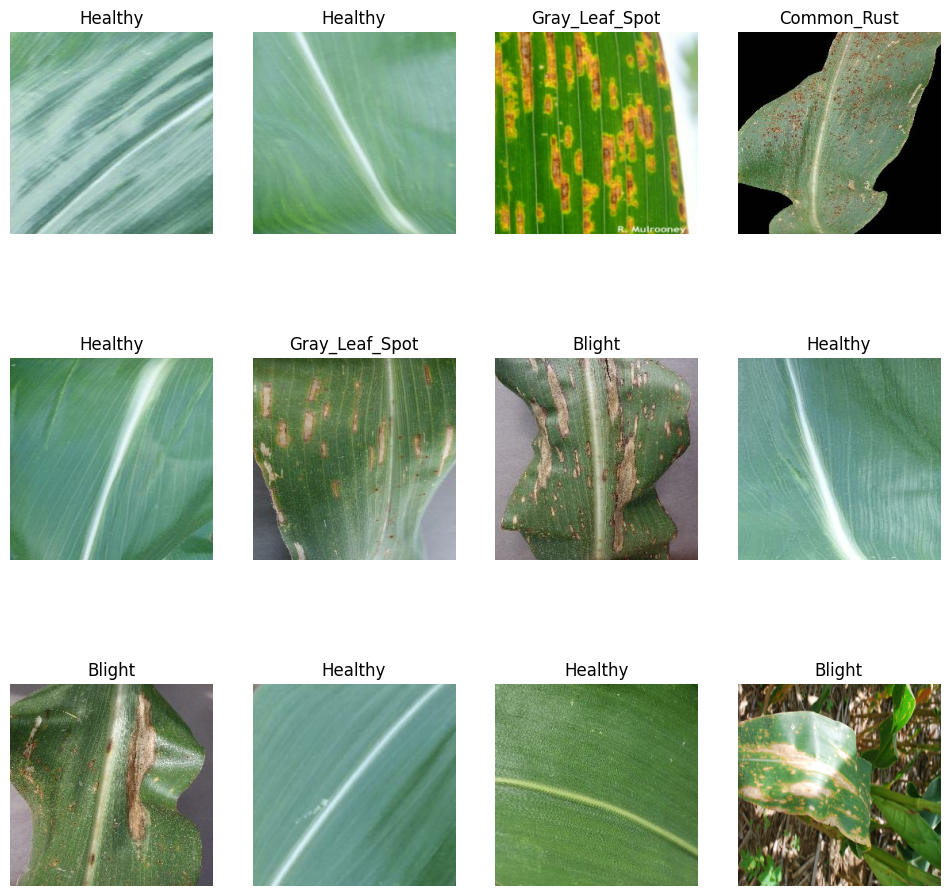

In [32]:
plt.figure(figsize=(12,12))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [33]:
len(dataset)

131

In [34]:
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [35]:
train_ds,val_ds,test_ds = get_dataset(dataset)

In [36]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [37]:
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(256,256),
layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [38]:
n_classes = 4
input_shape = (32,256,256,3)
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,(3,3),activation ='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),

])
model.build(input_shape=input_shape)

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [40]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # You can choose the metric to monitor, e.g., 'val_accuracy'
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored metric
)

# Model compilation and training
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training with EarlyStopping callback
history = model.fit(
    train_ds,
    epochs=30,
    batch_size=32,
    verbose=1,
    validation_data=val_ds,
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the list of callbacks
)

Epoch 1/30
104/104 [==============================] - 501s 5s/step - loss: 0.9897 - accuracy: 0.5009 - val_loss: 0.9200 - val_accuracy: 0.4808
Epoch 2/30
104/104 [==============================] - 436s 4s/step - loss: 0.8444 - accuracy: 0.5969 - val_loss: 0.9318 - val_accuracy: 0.6226
Epoch 3/30
104/104 [==============================] - 436s 4s/step - loss: 0.7925 - accuracy: 0.6450 - val_loss: 0.7550 - val_accuracy: 0.7404
Epoch 4/30
104/104 [==============================] - 442s 4s/step - loss: 0.4621 - accuracy: 0.8123 - val_loss: 0.4059 - val_accuracy: 0.8125
Epoch 5/30
104/104 [==============================] - 436s 4s/step - loss: 0.3481 - accuracy: 0.8502 - val_loss: 0.3314 - val_accuracy: 0.8534
Epoch 6/30
104/104 [==============================] - 437s 4s/step - loss: 0.3011 - accuracy: 0.8739 - val_loss: 0.3179 - val_accuracy: 0.8558
Epoch 7/30
104/104 [==============================] - 438s 4s/step - loss: 0.2902 - accuracy: 0.8794 - val_loss: 0.2880 - val_accuracy: 0.8702

In [43]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 33s 1s/step - loss: 0.0926 - accuracy: 0.9665


In [44]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

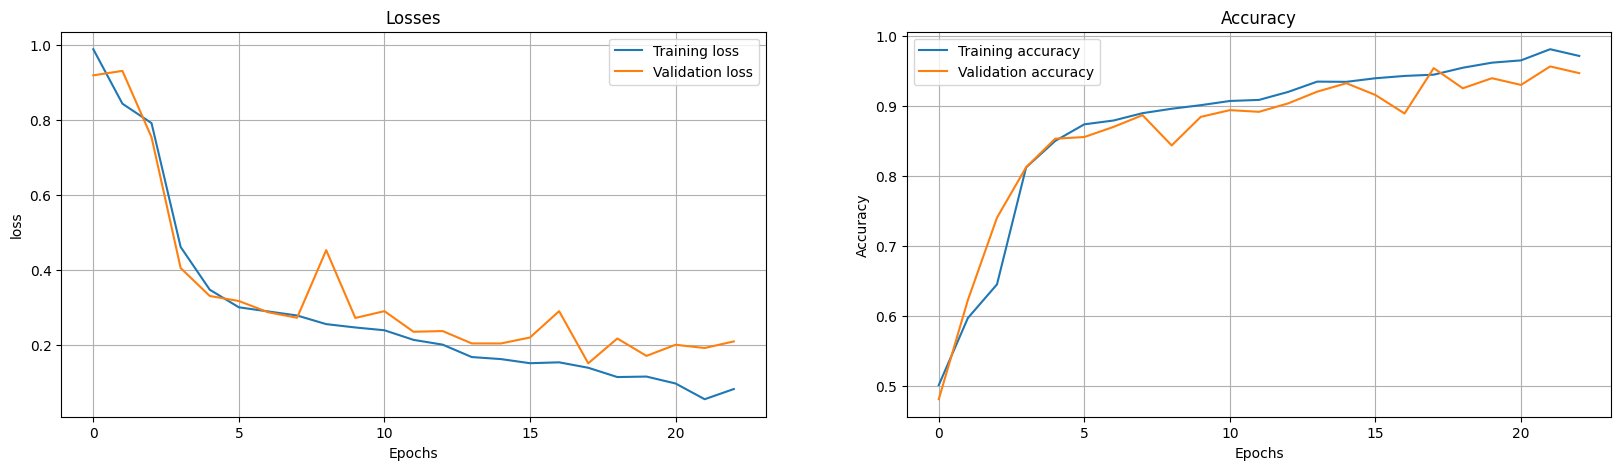

In [45]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

First Image to Predict :

Actual label: Common_Rust
1/1 [==============================] - 2s 2s/step

Predicted label Common_Rust


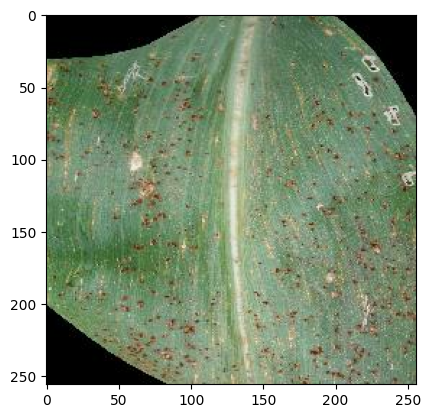

In [46]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First Image to Predict :")
    plt.imshow(first_image)
    print("\nActual label:",class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("\nPredicted label" ,class_names[np.argmax(batch_prediction[0])])

In [47]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 47ms/step


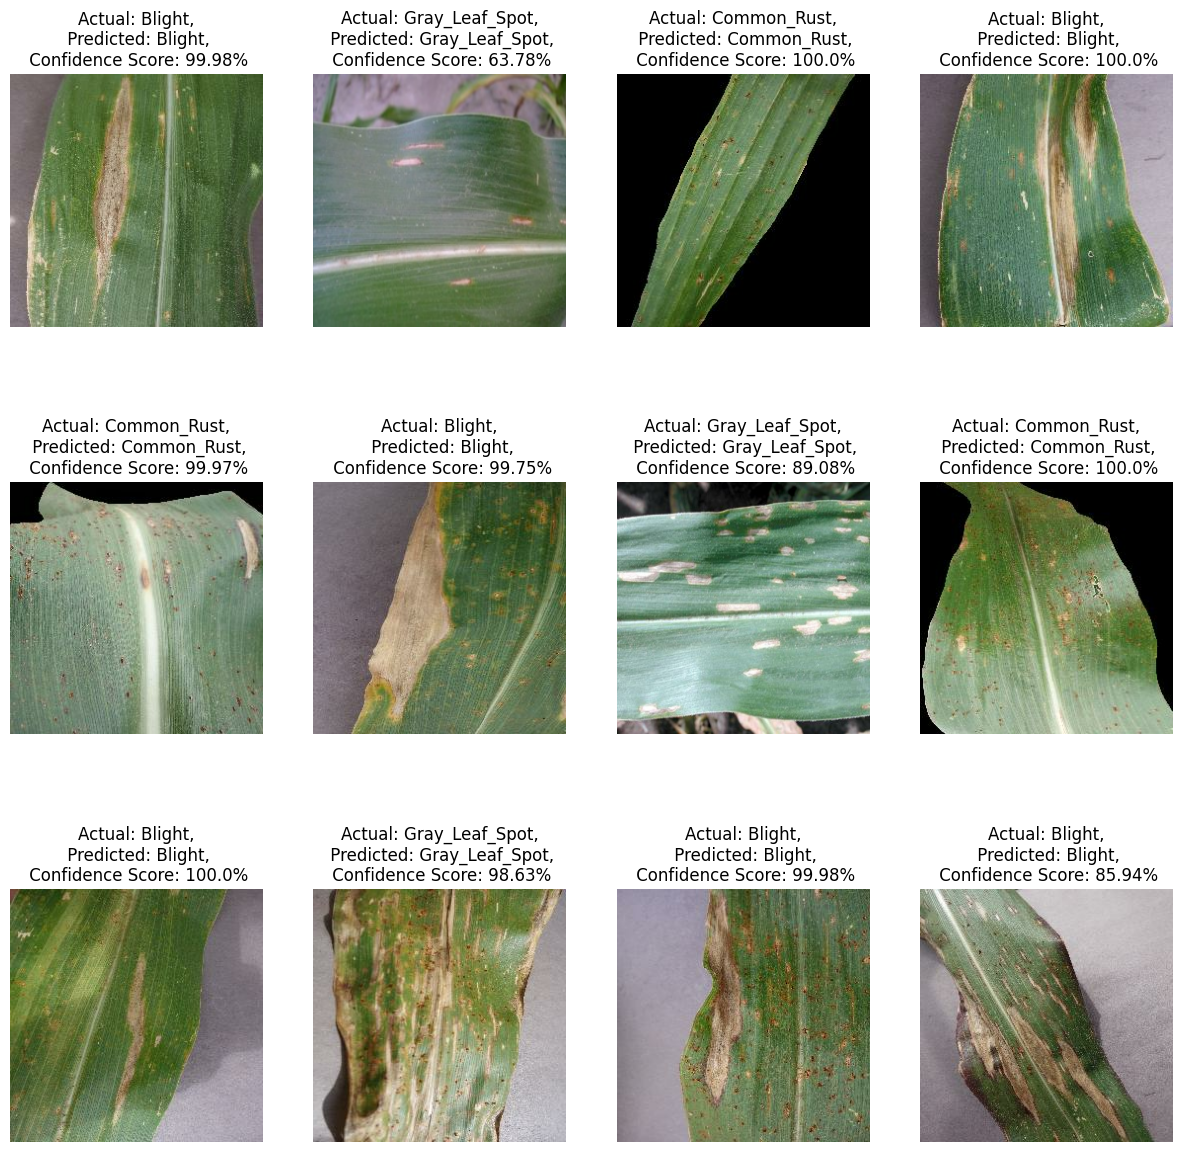

In [48]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [50]:
# model_version = 1
#model.save('/kaggle/working/Maize-Disease-Identification.h5')
#model.save('my_model.keras')
model.save('Maize-Disease-Identification.keras')

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
